[[0.56239691 0.67244677]
 [0.67244677 0.82020817]]
condition number: 208.10967999426205
Time taken for mask_calculate_rate_with_beta: 0.7462 seconds
Time taken for sgd_calculate_rate_with_beta: 0.3963 seconds


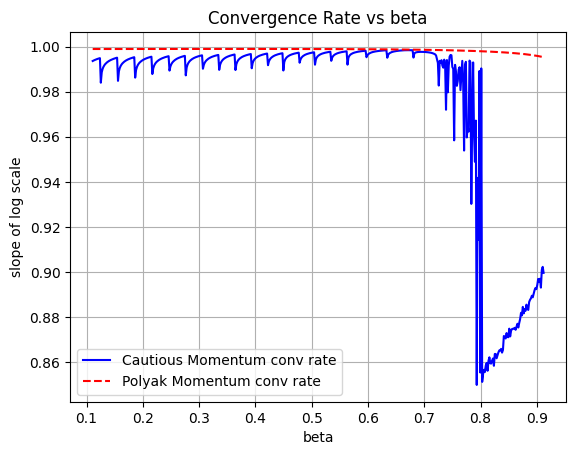

In [51]:
import time
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

T = 500
w0 = np.array([11.0, 10.0])


lmd = np.random.randn(2,2)
lmd = lmd @ lmd.T + 1e-6*np.eye(2)

print(lmd)
eigenvalues = np.linalg.eigvals(lmd)
k =np.max(eigenvalues) / np.min(eigenvalues)
print("condition number:", k)

alpha = 0.05
@njit
def compute_slope(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sum((x - x_mean) ** 2)
    return numerator / denominator

@njit
def sgd_calculate_rate_with_beta(beta):
    w = w0
    m = np.zeros(2)

    Ww = np.zeros(T + 1)
    Ww[0] = np.log10(np.linalg.norm(w0))

    for t in range(T):
        m = alpha * (lmd @ w) + beta * m
        w = w - m
        Ww[t + 1] = np.log10(np.linalg.norm(w))

    x = np.arange(len(Ww))
    y = Ww
    k = compute_slope(x, y)
    return 10**k

@njit
def mask_calculate_rate_with_beta(beta):
    w = w0
    m = np.zeros(2)

    Ww = np.zeros(T + 1)
    Ww[0] = np.log10(np.linalg.norm(w0))

    for t in range(T):

        
        m = alpha * (lmd @ w) + beta * m
        M = 0.5 * (np.sign(w) * np.sign(m) + 1)
        w = w - m * M
        Ww[t + 1] = np.log10(np.linalg.norm(w))


    x = np.arange(len(Ww))
    y = Ww
    k = compute_slope(x, y)
    return 10**k

# Generate beta values
# betas = np.linspace(1.111, 1.112, 5000)
betas = np.linspace(.111, .912, 500)
# Measure time for mask_calculate_rate_with_beta
start_time = time.time()
mask_rates_beta = np.array([mask_calculate_rate_with_beta(b) for b in betas])
mask_time = time.time() - start_time

# Measure time for sgd_calculate_rate_with_beta
start_time = time.time()
sgd_rates_beta = np.array([sgd_calculate_rate_with_beta(b) for b in betas])
sgd_time = time.time() - start_time

# Output timing results
print(f"Time taken for mask_calculate_rate_with_beta: {mask_time:.4f} seconds")
print(f"Time taken for sgd_calculate_rate_with_beta: {sgd_time:.4f} seconds")

# Plot rates vs beta
plt.plot(betas, mask_rates_beta, color='blue', label='Cautious Momentum conv rate')
plt.plot(betas, sgd_rates_beta, color='red', label='Polyak Momentum conv rate', linestyle='--')
plt.xlabel('beta')
plt.ylabel('slope of log scale')
plt.title('Convergence Rate vs beta')
plt.grid()
plt.legend()
plt.show()

